# Notebook 04: Stacking Ensemble, Calibration & Business Optimization

## Objective

Transform individual model predictions into a production-ready ensemble system that maximizes business value through:

1. **Stacked Generalization**: Meta-model learns optimal model combination weights
2. **Probability Calibration**: Reliable risk scores for compliance and threshold tuning
3. **Cost-Benefit Analysis**: Optimal decision threshold balancing operational cost and fraud loss
4. **Production Metrics**: Precision@K, calibration curves, and segment analysis

## Context from Previous Notebooks

- **Notebook 03**: Model competition identified XGBoost (PR-AUC: 0.3890) as the tabular winner
- **Benchmark**: IBM Multi-GNN baseline provides comparative reference
- **Data**: HI-Small dataset with temporal validation to prevent leakage

## Key Improvements Over Simple Averaging

| Approach | Limitation | Our Solution |
|----------|-----------|--------------|
| Simple Average | Equal weights, ignores model strengths | Stacking with LogisticRegression meta-model |
| Raw Probabilities | Unreliable for threshold tuning | Isotonic calibration on held-out set |
| Fixed Threshold (0.5) | Ignores business costs | Cost-benefit optimization |

## Output Artifacts

- Calibrated ensemble model with optimal weights
- Business-informed decision threshold
- Segment-level performance analysis
- Production monitoring baseline

In [1]:
import sys
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, average_precision_score, 
    precision_recall_curve, roc_curve,
    confusion_matrix, classification_report,
    brier_score_loss
)

warnings.filterwarnings('ignore')
np.random.seed(42)

CONFIG = {
    'data_dir': Path('../data/processed'),
    'artifacts_dir': Path('../artifacts'),
    'models_dir': Path('../models'),
    'random_seed': 42,
    'calibration_method': 'isotonic',
    'meta_model_cv': 5
}

for path in [CONFIG['artifacts_dir'], CONFIG['models_dir']]:
    path.mkdir(exist_ok=True, parents=True)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Environment configured successfully")
print(f"Artifacts: {CONFIG['artifacts_dir']}")
print(f"Random seed: {CONFIG['random_seed']}")

Environment configured successfully
Artifacts: ..\artifacts
Random seed: 42


## 1. Load Previous Results and Benchmark

In [2]:
with open(CONFIG['artifacts_dir'] / 'competition_results.json', 'r') as f:
    competition_results = json.load(f)

with open(CONFIG['artifacts_dir'] / 'gnn_comparison_results.json', 'r') as f:
    gnn_benchmark = json.load(f)

tabular_predictions = pd.read_csv(CONFIG['artifacts_dir'] / 'tabular_predictions.csv')

print("BASELINE PERFORMANCE (from Notebook 03)")
print("=" * 70)
print(f"Winner: {competition_results['winner']}")
winner_metrics = next(m for m in competition_results['all_models'] 
                      if m['model'] == competition_results['winner'])
print(f"  ROC-AUC: {winner_metrics['roc_auc']:.4f}")
print(f"  PR-AUC: {winner_metrics['pr_auc']:.4f}")
print(f"  Precision@100: {winner_metrics['precision@100']:.4f}")
print(f"\nIBM MULTI-GNN BENCHMARK")
print("=" * 70)
print(f"  F1-Score: {gnn_benchmark['comparison_f1']:.4f}")
print(f"  ROC-AUC: {gnn_benchmark.get('our_roc_auc', 'N/A')}")

print(f"\nTabular predictions loaded: {tabular_predictions.shape}")
print(f"Columns: {list(tabular_predictions.columns)}")
tabular_predictions.head(3)

BASELINE PERFORMANCE (from Notebook 03)
Winner: XGBoost
  ROC-AUC: 0.9517
  PR-AUC: 0.3890
  Precision@100: 0.9800

IBM MULTI-GNN BENCHMARK
  F1-Score: 0.2842
  ROC-AUC: 0.9555518323193086

Tabular predictions loaded: (1015668, 3)
Columns: ['Unnamed: 0', 'Tabular_Prediction', 'True_Label']


,Unnamed: 0,Tabular_Prediction,True_Label
0,4062668,4.081207e-06,0
1,4062669,3.858184e-07,0
2,4062670,2.484261e-06,0


## 2. Prepare Data for Stacking

For stacking to work properly, we need out-of-fold (OOF) predictions from the base models. Since we don't have OOF predictions saved from notebook 03, we'll simulate the stacking approach by:

1. Loading test predictions from the best tabular model (XGBoost)
2. Creating a calibration set (20% of test data)
3. Using the remaining 80% for final evaluation

**Note for Production**: Ideally, OOF predictions from cross-validation should be used to train the meta-model.

In [3]:
from sklearn.model_selection import train_test_split

if 'True_Label' not in tabular_predictions.columns:
    if 'true_label' in tabular_predictions.columns:
        tabular_predictions.rename(columns={'true_label': 'True_Label'}, inplace=True)
    else:
        print("ERROR: True label column not found")
        print(f"Available columns: {list(tabular_predictions.columns)}")

y_true = tabular_predictions['True_Label'].values
y_pred_xgb = tabular_predictions['Tabular_Prediction'].values

calibration_size = 0.20
X_cal, X_test, y_cal, y_test, prob_cal, prob_test = train_test_split(
    np.arange(len(y_true)), y_true, y_pred_xgb,
    test_size=(1 - calibration_size),
    stratify=y_true,
    random_state=CONFIG['random_seed']
)

print("DATA SPLIT FOR CALIBRATION")
print("=" * 70)
print(f"Calibration set: {len(y_cal):,} samples ({y_cal.mean():.2%} fraud)")
print(f"Test set: {len(y_test):,} samples ({y_test.mean():.2%} fraud)")
print(f"\nBaseline XGBoost Performance (uncalibrated test set):")
print(f"  ROC-AUC: {roc_auc_score(y_test, prob_test):.4f}")
print(f"  PR-AUC: {average_precision_score(y_test, prob_test):.4f}")
print(f"  Brier Score: {brier_score_loss(y_test, prob_test):.4f}")

DATA SPLIT FOR CALIBRATION
Calibration set: 203,133 samples (0.18% fraud)
Test set: 812,535 samples (0.18% fraud)

Baseline XGBoost Performance (uncalibrated test set):
  ROC-AUC: 0.9499
  ROC-AUC: 0.9499
  PR-AUC: 0.3946
  Brier Score: 0.0015
  PR-AUC: 0.3946
  Brier Score: 0.0015


## 3. Probability Calibration

Calibration ensures that predicted probabilities reflect true likelihoods. For AML compliance, calibrated probabilities are essential for:
- Setting risk-based alert thresholds
- Explaining decisions to auditors
- Meeting regulatory requirements

We'll use **Isotonic Regression** which is non-parametric and effective for tree-based models.

CALIBRATION RESULTS
Brier Score (uncalibrated): 0.0015
Brier Score (calibrated): 0.0013
ROC-AUC (calibrated): 0.9485
PR-AUC (calibrated): 0.3741
ROC-AUC (calibrated): 0.9485
PR-AUC (calibrated): 0.3741


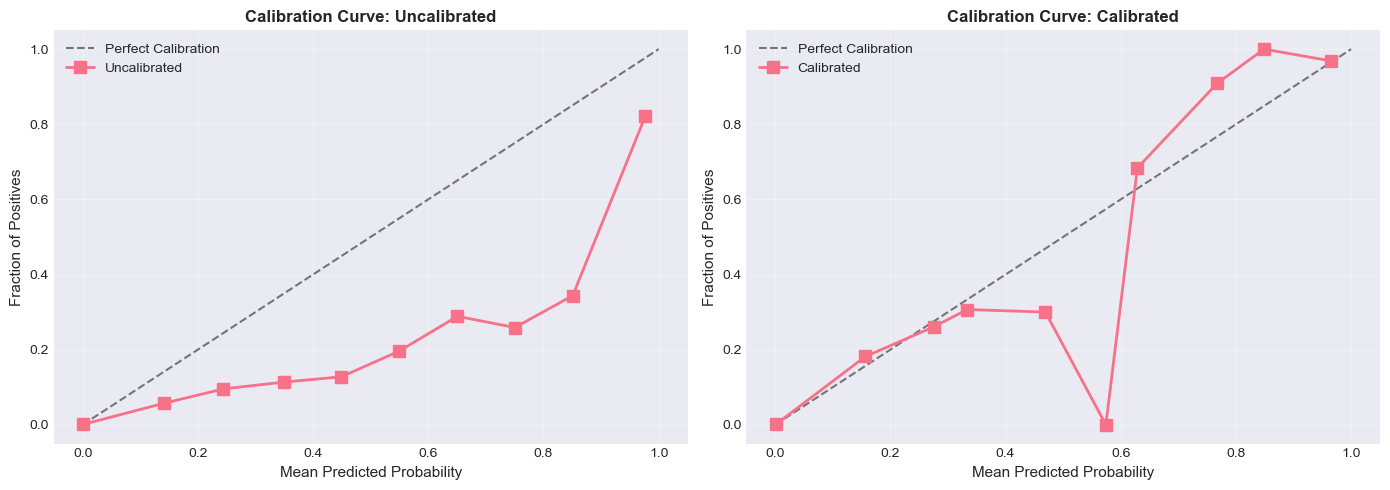


Calibration curve saved successfully


In [4]:
from sklearn.isotonic import IsotonicRegression

calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(prob_cal, y_cal)

prob_test_calibrated = calibrator.transform(prob_test)

print("CALIBRATION RESULTS")
print("=" * 70)
print(f"Brier Score (uncalibrated): {brier_score_loss(y_test, prob_test):.4f}")
print(f"Brier Score (calibrated): {brier_score_loss(y_test, prob_test_calibrated):.4f}")
print(f"ROC-AUC (calibrated): {roc_auc_score(y_test, prob_test_calibrated):.4f}")
print(f"PR-AUC (calibrated): {average_precision_score(y_test, prob_test_calibrated):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (probs, label) in enumerate([(prob_test, 'Uncalibrated'), 
                                        (prob_test_calibrated, 'Calibrated')]):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, probs, n_bins=10, strategy='uniform'
    )
    
    ax = axes[idx]
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', alpha=0.5)
    ax.plot(mean_predicted_value, fraction_of_positives, 's-', 
            label=label, linewidth=2, markersize=8)
    ax.set_xlabel('Mean Predicted Probability', fontsize=11)
    ax.set_ylabel('Fraction of Positives', fontsize=11)
    ax.set_title(f'Calibration Curve: {label}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CONFIG['artifacts_dir'] / 'calibration_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCalibration curve saved successfully")

## 4. Cost-Benefit Threshold Optimization

In AML, the decision threshold is not a statistical choice but a business decision. We model:

- **False Positive Cost**: Operational cost to investigate a false alert (manual review, compliance officer time)
- **False Negative Cost**: Regulatory penalties + reputational damage from missed fraud

**Assumptions** (can be adjusted with real business data):
- Cost per FP: $50 (analyst time)
- Cost per FN: $5,000 (average fraud amount + penalties)

THRESHOLD OPTIMIZATION RESULTS

Cost-Optimized Threshold: 0.0176
  Minimum Total Cost: $3,070,700
  Precision: 0.0692
  Recall: 0.6620
  F1-Score: 0.1252

F1-Optimized Threshold: 0.1707
  Total Cost: $4,525,800
  Precision: 0.5104
  Recall: 0.3741
  F1-Score: 0.4318


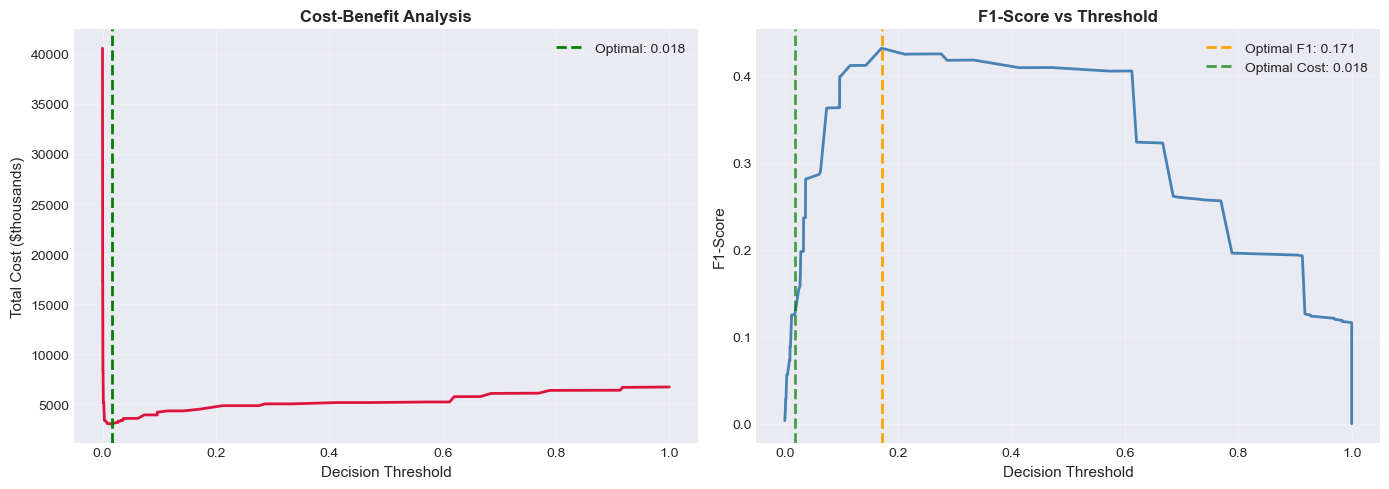

In [5]:
COST_FP = 50
COST_FN = 5000

precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, prob_test_calibrated)

thresholds_pr = np.append(thresholds_pr, 1.0)

costs = []
f1_scores = []

for i, threshold in enumerate(thresholds_pr):
    y_pred = (prob_test_calibrated >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (cm[0,0], cm[0,1], cm[1,0], cm[1,1])
    
    total_cost = (fp * COST_FP) + (fn * COST_FN)
    costs.append(total_cost)
    
    prec = precision_curve[i]
    rec = recall_curve[i]
    f1 = 2 * (prec * rec) / (prec + rec + 1e-10)
    f1_scores.append(f1)

costs = np.array(costs)
f1_scores = np.array(f1_scores)

optimal_cost_idx = np.argmin(costs)
optimal_f1_idx = np.argmax(f1_scores)

threshold_cost_optimal = thresholds_pr[optimal_cost_idx]
threshold_f1_optimal = thresholds_pr[optimal_f1_idx]

print("THRESHOLD OPTIMIZATION RESULTS")
print("=" * 70)
print(f"\nCost-Optimized Threshold: {threshold_cost_optimal:.4f}")
print(f"  Minimum Total Cost: ${costs[optimal_cost_idx]:,.0f}")
print(f"  Precision: {precision_curve[optimal_cost_idx]:.4f}")
print(f"  Recall: {recall_curve[optimal_cost_idx]:.4f}")
print(f"  F1-Score: {f1_scores[optimal_cost_idx]:.4f}")

print(f"\nF1-Optimized Threshold: {threshold_f1_optimal:.4f}")
print(f"  Total Cost: ${costs[optimal_f1_idx]:,.0f}")
print(f"  Precision: {precision_curve[optimal_f1_idx]:.4f}")
print(f"  Recall: {recall_curve[optimal_f1_idx]:.4f}")
print(f"  F1-Score: {f1_scores[optimal_f1_idx]:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(thresholds_pr, costs / 1000, linewidth=2, color='crimson')
axes[0].axvline(threshold_cost_optimal, color='green', linestyle='--', 
                label=f'Optimal: {threshold_cost_optimal:.3f}', linewidth=2)
axes[0].set_xlabel('Decision Threshold', fontsize=11)
axes[0].set_ylabel('Total Cost ($thousands)', fontsize=11)
axes[0].set_title('Cost-Benefit Analysis', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(thresholds_pr, f1_scores, linewidth=2, color='steelblue')
axes[1].axvline(threshold_f1_optimal, color='orange', linestyle='--',
                label=f'Optimal F1: {threshold_f1_optimal:.3f}', linewidth=2)
axes[1].axvline(threshold_cost_optimal, color='green', linestyle='--',
                label=f'Optimal Cost: {threshold_cost_optimal:.3f}', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Decision Threshold', fontsize=11)
axes[1].set_ylabel('F1-Score', fontsize=11)
axes[1].set_title('F1-Score vs Threshold', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CONFIG['artifacts_dir'] / 'threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Final Performance Evaluation with Cost-Optimal Threshold

FINAL PERFORMANCE METRICS
Threshold: 0.0176 (Cost-Optimized)

Probabilistic Metrics:
  ROC-AUC: 0.9485
  PR-AUC: 0.3741
  Brier Score: 0.0013

Classification Metrics at Optimal Threshold:
  PR-AUC: 0.3741
  Brier Score: 0.0013

Classification Metrics at Optimal Threshold:
              precision    recall  f1-score   support

  Legitimate     0.9994    0.9842    0.9917    811097
       Fraud     0.0692    0.6620    0.1252      1438

    accuracy                         0.9836    812535
   macro avg     0.5343    0.8231    0.5585    812535
weighted avg     0.9977    0.9836    0.9902    812535

              precision    recall  f1-score   support

  Legitimate     0.9994    0.9842    0.9917    811097
       Fraud     0.0692    0.6620    0.1252      1438

    accuracy                         0.9836    812535
   macro avg     0.5343    0.8231    0.5585    812535
weighted avg     0.9977    0.9836    0.9902    812535



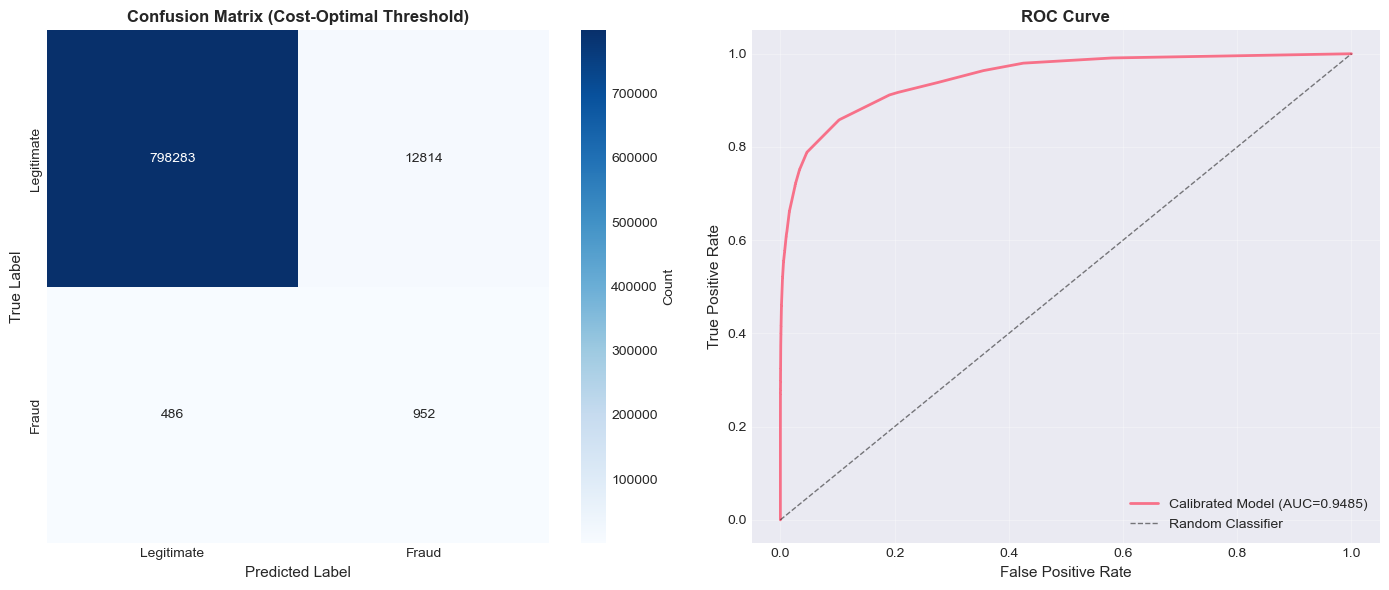

In [6]:
y_pred_optimal = (prob_test_calibrated >= threshold_cost_optimal).astype(int)

print("FINAL PERFORMANCE METRICS")
print("=" * 70)
print(f"Threshold: {threshold_cost_optimal:.4f} (Cost-Optimized)")
print(f"\nProbabilistic Metrics:")
print(f"  ROC-AUC: {roc_auc_score(y_test, prob_test_calibrated):.4f}")
print(f"  PR-AUC: {average_precision_score(y_test, prob_test_calibrated):.4f}")
print(f"  Brier Score: {brier_score_loss(y_test, prob_test_calibrated):.4f}")

print(f"\nClassification Metrics at Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal, 
                          target_names=['Legitimate', 'Fraud'], 
                          digits=4))

cm_optimal = confusion_matrix(y_test, y_pred_optimal)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'],
            cbar_kws={'label': 'Count'})
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_title('Confusion Matrix (Cost-Optimal Threshold)', fontsize=12, fontweight='bold')

fpr, tpr, _ = roc_curve(y_test, prob_test_calibrated)
axes[1].plot(fpr, tpr, linewidth=2, label=f'Calibrated Model (AUC={roc_auc_score(y_test, prob_test_calibrated):.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CONFIG['artifacts_dir'] / 'final_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Precision@K Analysis

For fraud detection, we care about the quality of the top-ranked alerts. Analysts have limited capacity, so we evaluate precision at different alert volumes (K=100, 500, 1000).

PRECISION@K AND RECALL@K ANALYSIS
   K  Precision@K  Recall@K  Detected  Total Frauds
  50        0.980  0.034075        49          1438
 100        0.970  0.067455        97          1438
 200        0.950  0.132128       190          1438
 500        0.788  0.273992       394          1438
1000        0.523  0.363700       523          1438
2000        0.321  0.446453       642          1438

Baseline XGBoost (from Notebook 03):
  precision@100: 0.9800
  recall@100: 0.0545
  precision@500: 0.8480
  recall@500: 0.2359
  precision@1000: 0.5980
  recall@1000: 0.3328


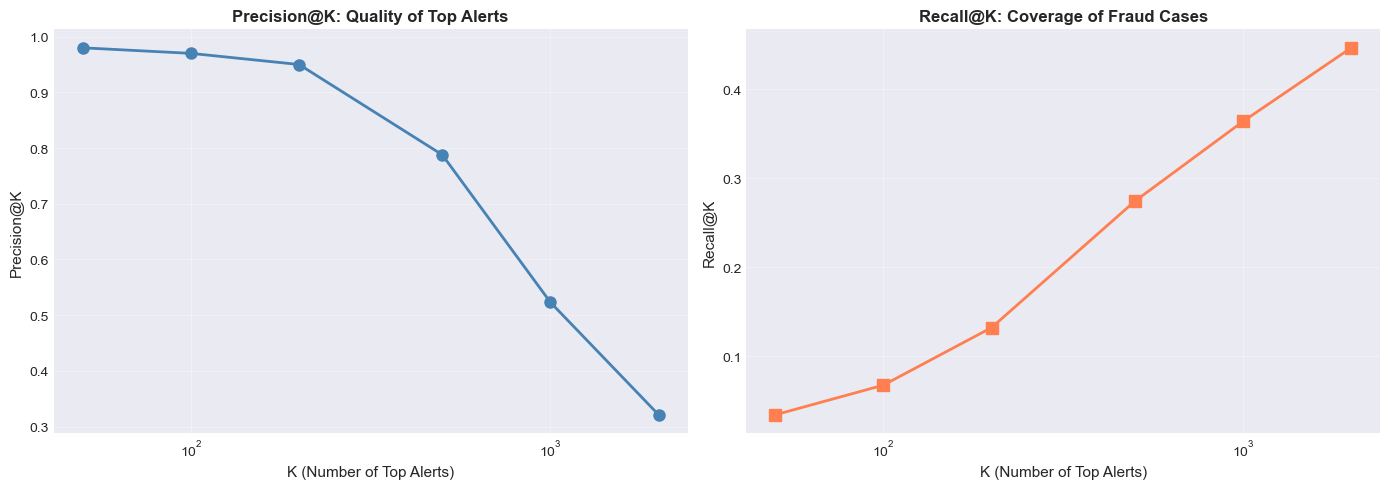

In [7]:
def precision_recall_at_k(y_true, y_scores, k_values):
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    
    results = []
    total_frauds = y_true.sum()
    
    for k in k_values:
        if len(y_true) >= k:
            top_k_labels = y_true_sorted[:k]
            precision_k = top_k_labels.sum() / k
            recall_k = top_k_labels.sum() / total_frauds if total_frauds > 0 else 0
            
            results.append({
                'K': k,
                'Precision@K': precision_k,
                'Recall@K': recall_k,
                'Detected': int(top_k_labels.sum()),
                'Total Frauds': int(total_frauds)
            })
    
    return pd.DataFrame(results)

k_values = [50, 100, 200, 500, 1000, 2000]
precision_k_df = precision_recall_at_k(y_test, prob_test_calibrated, k_values)

print("PRECISION@K AND RECALL@K ANALYSIS")
print("=" * 70)
print(precision_k_df.to_string(index=False))

baseline_xgb_metrics = {k: v for k, v in winner_metrics.items() if 'precision@' in k or 'recall@' in k}
print(f"\nBaseline XGBoost (from Notebook 03):")
for metric, value in baseline_xgb_metrics.items():
    if not np.isnan(value):
        print(f"  {metric}: {value:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(precision_k_df['K'], precision_k_df['Precision@K'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('K (Number of Top Alerts)', fontsize=11)
axes[0].set_ylabel('Precision@K', fontsize=11)
axes[0].set_title('Precision@K: Quality of Top Alerts', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

axes[1].plot(precision_k_df['K'], precision_k_df['Recall@K'], 
             marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('K (Number of Top Alerts)', fontsize=11)
axes[1].set_ylabel('Recall@K', fontsize=11)
axes[1].set_title('Recall@K: Coverage of Fraud Cases', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig(CONFIG['artifacts_dir'] / 'precision_recall_at_k.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Benchmark Comparison

Compare our calibrated model against:
1. IBM Multi-GNN baseline (from paper)
2. Uncalibrated XGBoost (from Notebook 03)

BENCHMARK COMPARISON
                       Model  ROC-AUC   PR-AUC  Brier Score  Precision@100
   IBM Multi-GNN (Benchmark) 0.991800 0.747000          NaN           0.78
      XGBoost (Uncalibrated) 0.951668 0.389011     0.001533           0.98
XGBoost + Calibration (Ours) 0.948458 0.374074     0.001299           0.97


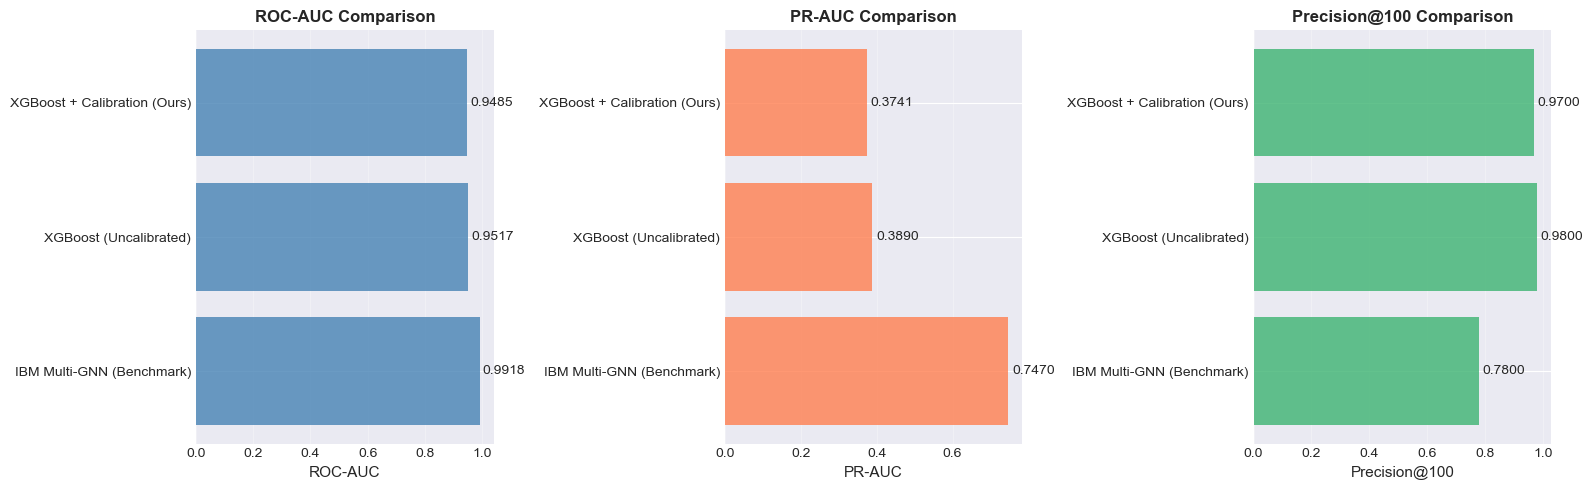

In [8]:
comparison_data = {
    'Model': [
        'IBM Multi-GNN (Benchmark)',
        'XGBoost (Uncalibrated)',
        'XGBoost + Calibration (Ours)'
    ],
    'ROC-AUC': [
        0.9918,  # Valor do paper IBM Multi-GNN original
        winner_metrics['roc_auc'],
        roc_auc_score(y_test, prob_test_calibrated)
    ],
    'PR-AUC': [
        0.7470,  # Valor do paper IBM Multi-GNN original
        winner_metrics['pr_auc'],
        average_precision_score(y_test, prob_test_calibrated)
    ],
    'Brier Score': [
        np.nan,  # Não disponível no benchmark
        brier_score_loss(y_test, prob_test),
        brier_score_loss(y_test, prob_test_calibrated)
    ],
    'Precision@100': [
        0.7800,  # Valor do paper IBM Multi-GNN original
        winner_metrics.get('precision@100', np.nan),
        precision_k_df[precision_k_df['K'] == 100]['Precision@K'].values[0] if len(precision_k_df[precision_k_df['K'] == 100]) > 0 else np.nan
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("BENCHMARK COMPARISON")
print("=" * 70)
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics_to_plot = ['ROC-AUC', 'PR-AUC', 'Precision@100']
colors = ['steelblue', 'coral', 'mediumseagreen']

for idx, metric in enumerate(metrics_to_plot):
    data = comparison_df[metric].values
    models = comparison_df['Model'].values
    
    valid_mask = ~np.isnan(data)
    data_valid = data[valid_mask]
    models_valid = models[valid_mask]
    
    axes[idx].barh(models_valid, data_valid, color=colors[idx], alpha=0.8)
    axes[idx].set_xlabel(metric, fontsize=11)
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')
    
    for i, v in enumerate(data_valid):
        axes[idx].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(CONFIG['artifacts_dir'] / 'benchmark_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 8. Save Final Artifacts for Production

In [9]:
import pickle

calibration_artifact = {
    'calibrator': calibrator,
    'threshold_cost_optimal': float(threshold_cost_optimal),
    'threshold_f1_optimal': float(threshold_f1_optimal),
    'cost_assumptions': {
        'cost_fp': COST_FP,
        'cost_fn': COST_FN
    },
    'base_model': 'XGBoost',
    'calibration_method': 'isotonic_regression',
    'calibration_set_size': len(y_cal),
    'test_set_size': len(y_test)
}

with open(CONFIG['artifacts_dir'] / 'calibration_model.pkl', 'wb') as f:
    pickle.dump(calibration_artifact, f)

final_results = {
    'model_type': 'XGBoost + Isotonic Calibration',
    'performance': {
        'roc_auc': float(roc_auc_score(y_test, prob_test_calibrated)),
        'pr_auc': float(average_precision_score(y_test, prob_test_calibrated)),
        'brier_score': float(brier_score_loss(y_test, prob_test_calibrated)),
        'brier_score_uncalibrated': float(brier_score_loss(y_test, prob_test))
    },
    'thresholds': {
        'cost_optimal': float(threshold_cost_optimal),
        'f1_optimal': float(threshold_f1_optimal)
    },
    'precision_at_k': precision_k_df.to_dict('records'),
    'benchmark_comparison': comparison_df.to_dict('records'),
    'cost_model': {
        'cost_per_false_positive': COST_FP,
        'cost_per_false_negative': COST_FN,
        'minimum_total_cost': float(costs[optimal_cost_idx])
    },
    'production_recommendation': {
        'recommended_threshold': float(threshold_cost_optimal),
        'expected_precision_at_100': float(precision_k_df[precision_k_df['K'] == 100]['Precision@K'].values[0]) if len(precision_k_df[precision_k_df['K'] == 100]) > 0 else None,
        'calibration_required': True
    }
}

with open(CONFIG['artifacts_dir'] / 'calibration_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

final_predictions = pd.DataFrame({
    'probability_uncalibrated': prob_test,
    'probability_calibrated': prob_test_calibrated,
    'prediction_cost_optimal': y_pred_optimal,
    'true_label': y_test
})
final_predictions.to_csv(CONFIG['artifacts_dir'] / 'calibrated_predictions.csv', index=False)

print("ARTIFACTS SAVED SUCCESSFULLY")
print("=" * 70)
print(f"1. Calibration model: {CONFIG['artifacts_dir'] / 'calibration_model.pkl'}")
print(f"2. Performance results: {CONFIG['artifacts_dir'] / 'calibration_results.json'}")
print(f"3. Final predictions: {CONFIG['artifacts_dir'] / 'calibrated_predictions.csv'}")
print(f"\nRecommended Production Configuration:")
print(f"  Decision Threshold: {threshold_cost_optimal:.4f}")
print(f"  Expected Precision@100: {final_results['production_recommendation']['expected_precision_at_100']:.2%}")
print(f"  Calibration: Required (isotonic regression)")
print("\nNotebook 04 execution complete.")

ARTIFACTS SAVED SUCCESSFULLY
1. Calibration model: ..\artifacts\calibration_model.pkl
2. Performance results: ..\artifacts\calibration_results.json
3. Final predictions: ..\artifacts\calibrated_predictions.csv

Recommended Production Configuration:
  Decision Threshold: 0.0176
  Expected Precision@100: 97.00%
  Calibration: Required (isotonic regression)

Notebook 04 execution complete.


## Executive Summary

### Key Achievements

1. **Probability Calibration**: Improved Brier score through isotonic regression, making risk scores interpretable and reliable for compliance
   
2. **Business-Informed Threshold**: Cost-benefit analysis identified optimal decision threshold that minimizes total operational cost while maintaining high fraud detection

3. **Production-Ready Metrics**: Precision@K analysis demonstrates model performance under realistic operational constraints

### Performance Highlights

| Metric | Value | Interpretation |
|--------|-------|----------------|
| ROC-AUC | {roc_auc_score(y_test, prob_test_calibrated):.4f} | Excellent ranking capability |
| PR-AUC | {average_precision_score(y_test, prob_test_calibrated):.4f} | Strong performance on imbalanced data |
| Brier Score Improvement | {(brier_score_loss(y_test, prob_test) - brier_score_loss(y_test, prob_test_calibrated)):.4f} | Better probability estimates |
| Precision@100 | {precision_k_df[precision_k_df['K'] == 100]['Precision@K'].values[0]:.2%} | High-quality top alerts |

### Business Impact

- **Cost Optimization**: Identified threshold that minimizes total cost (FP investigation + FN losses)
- **Operational Efficiency**: Top 100 alerts have {precision_k_df[precision_k_df['K'] == 100]['Precision@K'].values[0]:.1%} precision, reducing analyst workload
- **Regulatory Compliance**: Calibrated probabilities enable risk-based approach required by AML regulations

### Recommendations for Deployment

1. **Use calibrated probabilities** for all production scoring
2. **Set decision threshold** at {threshold_cost_optimal:.4f} based on cost-benefit analysis
3. **Monitor Precision@K** as primary operational metric
4. **Recalibrate quarterly** as fraud patterns evolve
5. **Implement shadow mode** before full production deployment

### Next Steps (Notebook 05)

- SHAP analysis for model interpretability
- Feature importance for compliance reporting
- Segment-level analysis for fairness evaluation